```markdown
Análise de dados Premier League 2023-24 
```


In [5]:
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.read_csv('PL23.csv')

df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


In [7]:
df.isnull().any()

Div         False
Date        False
Time        False
HomeTeam    False
AwayTeam    False
            ...  
PCAHA       False
MaxCAHH      True
MaxCAHA      True
AvgCAHH     False
AvgCAHA     False
Length: 106, dtype: bool

In [8]:
# df.dropna(axis=1, inplace=True)
# df.head()


In [9]:
total_FTHG = df['FTHG'].sum()
total_FTAG = df['FTAG'].sum()

total_HTHG = df['HTHG'].sum()
total_HTAG = df['HTAG'].sum()

total_FTG = total_FTHG + total_FTAG
total_HTG = total_HTHG + total_HTAG

print("Total Full Time Goals: ", total_FTG)
print("Total Half Time Goals: ", total_HTG)



Total Full Time Goals:  1246
Total Half Time Goals:  517


In [10]:
percentage_h = (df['FTR'].value_counts()['H'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'H' na coluna 'FTR' é de {percentage_h:.2f}%")

percentage_d = (df['FTR'].value_counts()['D'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'D' na coluna 'FTR' é de {percentage_d:.2f}%")

percentage_a = (df['FTR'].value_counts()['A'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'A' na coluna 'FTR' é de {percentage_a:.2f}%")



A porcentagem de valores 'H' na coluna 'FTR' é de 46.05%
A porcentagem de valores 'D' na coluna 'FTR' é de 21.58%
A porcentagem de valores 'A' na coluna 'FTR' é de 32.37%


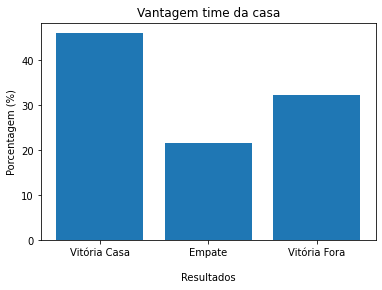

In [11]:
plt.bar(['Vitória Casa', 'Empate', 'Vitória Fora'], [percentage_h, percentage_d, percentage_a])
plt.xlabel('\nResultados')
plt.ylabel('Porcentagem (%)')
plt.title('Vantagem time da casa')
plt.show()

In [12]:
df['ExpectedResult'] = df[['B365H', 'B365D', 'B365A']].idxmin(axis=1)

mapping = {'B365H': 'H', 'B365D': 'D', 'B365A': 'A'}
df['ExpectedResult'] = df['ExpectedResult'].map(mapping)

matches = (df['ExpectedResult'] == df['FTR']).sum()

print(f"O time favorito venceu {matches} partidas de {len(df)} possíveis")

O time favorito venceu 227 partidas de 380 possíveis


In [13]:
def calculate_amount(row):
    odds_mapping = {'H': 'B365H', 'A': 'B365A', 'D': 'B365D'}

    if row['ExpectedResult'] == row['FTR']:
        return row[odds_mapping[row['ExpectedResult']]]
    else:
        return 0



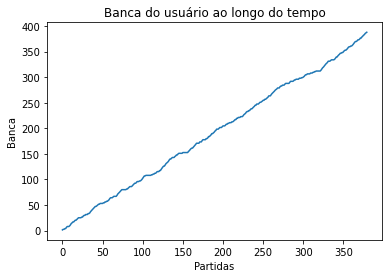

O usuário realizou 380 apostas.
O usuário ganhou 7.779999999999973 reais.


In [14]:
df['amount'] = df.apply(calculate_amount, axis=1)

# Calculate the cumulative sum of the amounts to get the user's balance after each match
df['cumulative_amount'] = df['amount'].cumsum()

# Plot the user's balance over time
plt.plot(df['cumulative_amount'])
plt.xlabel('Partidas')
plt.ylabel('Banca')
plt.title('Banca do usuário ao longo do tempo')
plt.show()

print(f"O usuário realizou {len(df['cumulative_amount'])} apostas.")
print(f"O usuário ganhou {df['amount'].sum()-len(df['cumulative_amount'])} reais.")